In [12]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.datasets

In [13]:
# classification problem

# class A comes from N([-1,-1], I)
# class B comes from N([1, 1], I)
mean_classA = np.array([-1 , -1])
mean_classB = np.array([1 , 1])
cov = 1*np.identity(n=2)

# draw points from multivariate gaussian
N = 50
X_classA = np.random.multivariate_normal(mean_classA, cov, N//2)
X_classB = np.random.multivariate_normal(mean_classB, cov, N//2)
X = np.concatenate((X_classA, X_classB))

y_classA = np.full((N//2, ), 1, dtype=np.bool_)
y_classB = np.full((N//2, ), 0, dtype=np.bool_)
y = np.concatenate((y_classA, y_classB))

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

X.shape, y.shape

(torch.Size([50, 2]), torch.Size([50]))

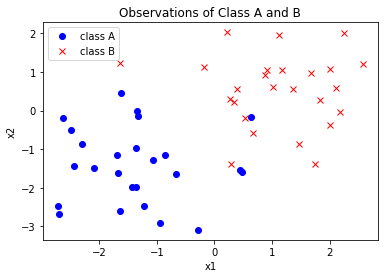

In [14]:
plt.plot(X_classA[:, 0], X_classA[:, 1], "bo", label="class A")
plt.plot(X_classB[:, 0], X_classB[:, 1], "rx", label="class B")
plt.title("Observations of Class A and B")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()

In [15]:
# solve the classification problem with pytorch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 1, bias=True) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [16]:
# run a single observation through the network
net = Net()
criterion = nn.BCELoss()
optim = torch.optim.SGD(net.parameters(), lr=0.01)

xx = X[0].reshape((1, -1))
yy = y[0].reshape(-1)

print(xx.shape, yy.shape)

net.zero_grad()
out = net(xx)
out = out.reshape((-1, ))
loss = criterion(out, yy)

torch.Size([1, 2]) torch.Size([1])


Final Accuracy: 94.0%


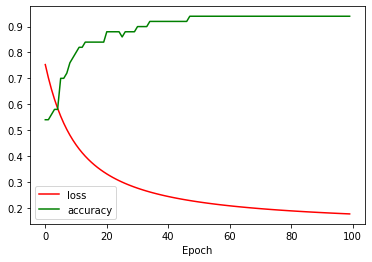

In [17]:
# training loop 
net = Net()
criterion = nn.BCELoss()
optim = torch.optim.SGD(net.parameters(), lr=0.1)

EPOCHS = 100
losses = []
accuracies = []
for i in range(EPOCHS):
    net.zero_grad()
    out = net(X)
    out = out.reshape((-1, ))
    
    loss = criterion(out, y)
    losses.append(loss)
    
    preds = out > 0.5
    accuracy = np.sum(preds.detach().numpy() == y.numpy()) / X.shape[0]
    accuracies.append(accuracy)
    
    loss.backward()
    optim.step()


print(f"Final Accuracy: {accuracy*100}%")

plt.plot(losses, "r-", label="loss")
plt.plot(accuracies, "g-", label="accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [18]:
# print learnable parameters
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.data)

weights = [param.data for name, param in net.named_parameters() if "weight" in name][0].reshape(-1,)
bias = [param.data for name, param in net.named_parameters() if "bias" in name][0]

weights, bias

fc1.weight tensor([[-1.3195, -1.1203]])
fc1.bias tensor([-0.1986])


(tensor([-1.3195, -1.1203]), tensor([-0.1986]))

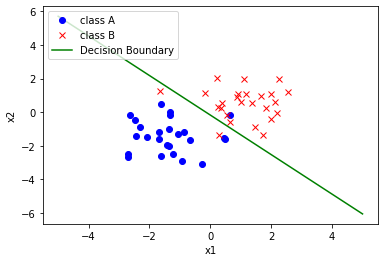

In [19]:
# plot the learned decision boundary
# TODO

# yhat = b + w0*x_{i,1} + w1*x_{i,2}

def decision_boundary(x1, bias, weights):
    intercept = -bias/weights[1]
    slope = -weights[0]/weights[1]
    return intercept + slope*x1

xx = np.linspace(-5, 5, 50)
yy = decision_boundary(xx, bias, weights)

plt.plot(X_classA[:, 0], X_classA[:, 1], "bo", label="class A")
plt.plot(X_classB[:, 0], X_classB[:, 1], "rx", label="class B")
plt.plot(xx, yy, "g-", label="Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(loc="upper left")
plt.show()